# Kernel methods for a 3 dimensional Allen-Cahn PDE

Here we will solve the PDE

$$\begin{cases} \partial_t u - \Delta_\boldsymbol{x} u + \frac{1}{\epsilon^2} \left(u^3 - u\right) =0, & \boldsymbol{x} \in \Omega \times [0,T] \\ u(x,0) = u_0(x), & \boldsymbol{x} \in \Omega \times \{0\} \\ \nabla_\boldsymbol{x} u(\boldsymbol{x}) . n(\boldsymbol{x}) = 0, & \boldsymbol{x} \in \partial \Omega \times [0,T] \end{cases}$$

where $\Delta$ is the Laplacian, $T = 1$, $\Omega = [0,1]^2$, $\epsilon>0$ and $\nabla_\boldsymbol{x} u(\boldsymbol{x})$ is the normal derivative. 

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth

## PDE Setup

In [3]:
ns = torch.tensor([ # number of collocation points
    2**9, # on the interior
    2**8, # boundary initial condition
    2**8, # boundary left-right
    2**8, # boundary top-bottom
],dtype=int)
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True,True,True], # interior points (not projected to the 0 boundary)
    [False,True,True], # boundary points initial condition
    [True,True,False], # boundary points top-bottom
    [True,False,True], # boundary points left-right
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0,0,0]],dtype=int), # u
        torch.tensor([[1,0,0],[0,2,0],[0,0,2]],dtype=int), # du/dt - laplacian u
    ],
    [ # boundary initial condition
        torch.tensor([[0,0,0]],dtype=int) # u
    ],
    [ # boundary top-bottom
        torch.tensor([[0,0,1]],dtype=int) # du/dx2
    ],
    [ # boundary left-right
        torch.tensor([[0,1,0]],dtype=int), # du/dx1
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # u 
        torch.tensor([1,-1,-1],dtype=float) # du/dt - laplacian u
    ],
    [ # boundary initial condition
        torch.ones(1,dtype=float), # u
    ],
    [ # boundary top-bottom
        torch.ones(1,dtype=float) # du/dx2
    ],
    [ # boundary left-right
        torch.ones(1,dtype=float), # du/dx1
    ]
]

In [4]:
EPSILON = 1.
def u0_ic(x):
    x1,x2 = x[:,0],x[:,1]
    y = torch.zeros_like(x1)
    r = torch.sqrt((2*x1-1)**2+(2*x2-1)**2)
    b = r<1
    y[b] = torch.exp(-1/(1-r[b]**2))
    return y

In [5]:
def pde_lhs(ly_i, ly_ic, ly_bc_tb, ly_bc_lr):
    u_i,dudt_minus_laplace_u_i = ly_i
    u_ic = ly_ic[0]
    dudx2_tb = ly_bc_tb[0]
    dudx1_lr = ly_bc_lr[0]
    lhs_i = dudt_minus_laplace_u_i+1/EPSILON**2*(u_i**3-u_i)
    lhs_ic = u_ic 
    lhs_tb = dudx2_tb
    lhs_lr = dudx1_lr
    return lhs_i,lhs_ic,lhs_tb,lhs_lr
def pde_rhs(x_i, x_ic, x_bc_tb, x_bc_lr):
    y_i = torch.zeros(len(x_i),dtype=float)
    y_ic = u0_ic(x_ic[:,1:])
    y_bc_tb = torch.zeros(len(x_bc_tb),dtype=float)
    y_bc_lr = torch.zeros(len(x_bc_lr),dtype=float)
    return y_i,y_ic,y_bc_tb,y_bc_lr

## Kernel Interpolant 

### Construction

In [57]:
noise = 1e-8
lattice = qp.Lattice(dimension=3,seed=7) # collocation points
kernel = qp.KernelGaussian(dimension=3,lengthscales=1e-2,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(lattice,kernel,llbetas,llcs,noise,ns,us,half_comp=[True,False,True,True]) # kernel interpolant

### PDE Optimization

In [58]:
y,losses_opt,rerrors_opt,times_opt = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 8,
    solver = "CHOL",
    verbose = True)

	iter (8 max)        loss           
	1                   7.68e-02       
	2                   2.55e-03       
	3                   1.05e-10       
	4                   1.19e-13       
	5                   1.50e-13       
	6                   1.13e-13       
	7                   1.34e-13       
	8                   1.23e-13       


### Fitting

In [59]:
tticks = torch.linspace(0,1,11)
x1dticks = torch.linspace(0,1,26) 
tmesh,x1mesh,x2mesh = torch.meshgrid(tticks,x1dticks,x1dticks,indexing="ij")
xticks = torch.vstack([tmesh.flatten(),x1mesh.flatten(),x2mesh.flatten()]).T
print("xticks.shape = %s"%str(tuple(xticks.shape)))

xticks.shape = (7436, 3)


In [60]:
coeffs = ki._solve(y) 
#coeffs,rerrors_fit,times_fit = ki.pcg(y,precond=True)
kvec = ki.get_new_left_full_gram_matrix(xticks)
ymesh = (kvec@coeffs).reshape(tmesh.shape)
print("ymesh.shape = %s"%str(tuple(ymesh.shape)))

ymesh.shape = (11, 26, 26)


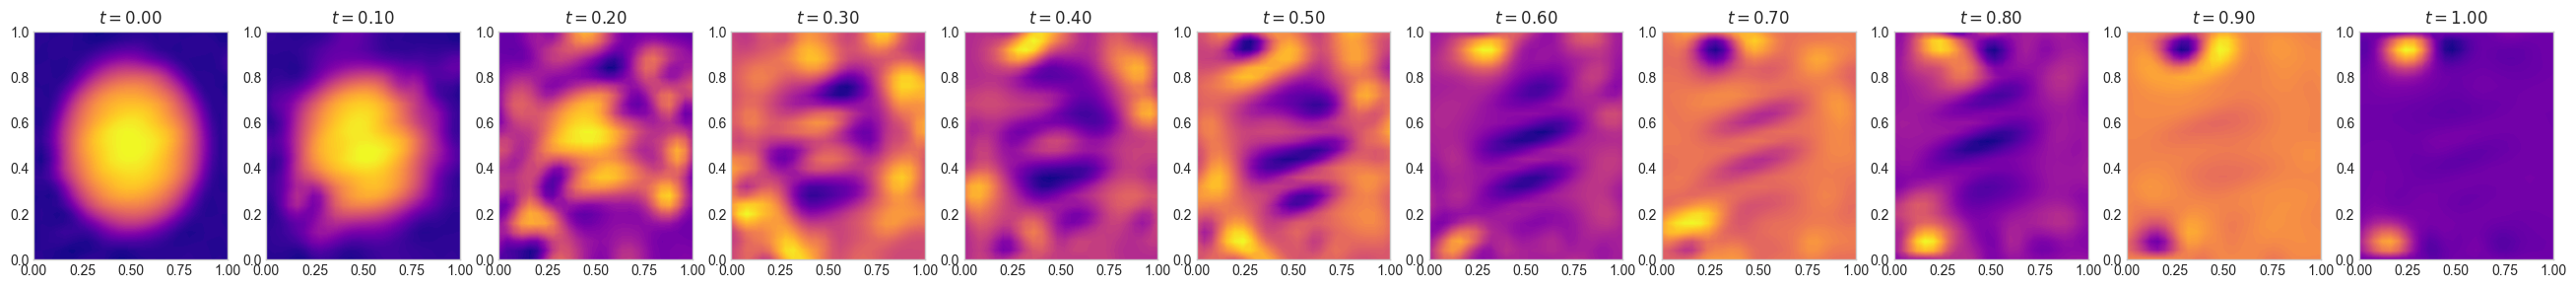

In [61]:
maxrows = fig,ax = pyplot.subplots(nrows=1,ncols=len(tticks),figsize=(3*len(tticks),3))
ymin,ymax = ymesh.min(),ymesh.max()
for i in range(len(tticks)):
    ax[i].contourf(x1mesh[i],x2mesh[i],ymesh[i],antialiased=False,cmap=cm.plasma,levels=100) # ,vmin=ymin,vmax=ymax
    ax[i].set_title("$t = %.2f$"%tticks[i])